# Mapeamento de Colaborações em Obras da UFRN
https://github.com/lumathias/ProjetoAED/edit/main/README.md

Luisa de Moura Galvão Mathias 20220080650

Viviane Stephane Pinheiro Novo 20240001144


# Instalações e importações

In [ ]:
!pip install networkx pandas matplotlib nxviz

In [ ]:
# Bibliotecas
import pandas as pd
import networkx as nx
import numpy as np
import io
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
from nxviz import CircosPlot
from itertools import combinations

In [ ]:
# Importação do computador
from google.colab import files
uploaded = files.upload()

# Carregando o arquivo CSV
df = pd.read_csv('obras.csv', sep=';')

Saving obras.csv to obras (2).csv


In [ ]:
print(df.head())

# Processamento

In [ ]:
# CRIAÇÃO DO GRAFO (Nós e Arestas)

G = nx.Graph() # grafo não direcionado

# Adiciona Nós de Obras e Nós de Empresas ao grafo
obras_nodes = df['id_obra'].unique()
empresas_nodes = df['empresa'].unique()

G.add_nodes_from(obras_nodes, bipartite=0, type='Obra')
G.add_nodes_from(empresas_nodes, bipartite=1, type='Empresa')

# limpa e converte 'valor' p/ valor numericoantes de add atributos de nós e arestas
df['valor_numeric'] = df['valor'].astype(str).str.replace('R$', '', regex=False).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).str.strip()
df['valor_numeric'] = pd.to_numeric(df['valor_numeric'], errors='coerce')


# adiciona arestas (Obra <--> Empresa)
for index, row in df.iterrows():
    id_obra = row['id_obra']
    empresa = row['empresa']
    valor_numeric = row['valor_numeric']
    status = row['status_obra']

    # add aresta com 'valor_numeric' como peso
    if pd.notna(valor_numeric): # só add aresta se valor não for NaN
        G.add_edge(id_obra, empresa, weight=valor_numeric, status_obra=status)

# adicionar atributos aos Nós
# status da obra --> nós de obra, e o valor total --> empresa
for node in G.nodes():
    if G.nodes[node]['type'] == 'Obra':
        # Add status e unidade responsável ao 'work node'
        obra_data = df[df['id_obra'] == node].iloc[0]
        G.nodes[node]['status'] = obra_data.get('status_obra', 'Unknown')
        G.nodes[node]['unidade'] = obra_data.get('unidade_responsavel')
        # Add o valor numerico como um atributo para os nós de Obra
        G.nodes[node]['valor_associado'] = obra_data.get('valor_numeric', 0)
    elif G.nodes[node]['type'] == 'Empresa':
        # Calcula o valor total de projetos da empresa somando os pesos
        total_valor = sum(data.get('weight', 0) for u, v, data in G.edges(node, data=True))
        G.nodes[node]['valor_associado'] = total_valor


print(f"\n Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")


 Grafo criado com 1053 nós e 848 arestas.


In [ ]:
# CÁLCULO DE MÉTRICAS DA REDE

# Propriedades Básicas
print(f"\n----- Análise de Propriedades Básicas -----")
print(f"Número de Nós: {G.number_of_nodes()}")
print(f"Número de Arestas: {G.number_of_edges()}")
densidade = nx.density(G) # densidade da Rede
print(f"Densidade da Rede (conexão entre nós): {densidade:.4f}")

# grau dos Nós
degree_dict = dict(G.degree())
print(f"\n----- Análise de Grau dos Nós -----")
# filtra e mostra o grau das Empresas (quantas obras executaram)
for node, degree in degree_dict.items():
    if node in empresas_nodes:
        print(f"Empresa '{node}': Grau {degree}")

# assortatividade da rede
# Mede se nós de alto grau (Empresas grandes) tendem a se conectar com outros de alto grau
assortativity = nx.degree_assortativity_coefficient(G)
print(f"\nAssortatividade por Grau: {assortativity:.4f}")
# é esperado próximo de 0 para obra-empresa


--- Análise de Propriedades Básicas ---
Número de Nós: 1053
Número de Arestas: 848
Densidade da Rede (conexão entre nós): 0.0015

--- Análise de Grau dos Nós ---
Empresa ' 03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREENDIMENTOS': Grau 5
Empresa ' 40.761.454/0001-08 - AR PROJETOS & CONSTRUÇÕES LTDA': Grau 8
Empresa ' 03.722.669/0001-85 - CONSTRUTORA CAGEO LTDA': Grau 12
Empresa ' 01.694.415/0001-75 - HASTE-HABITAÇÃO E SERVIÇOS TÉCNICOS LTDA': Grau 10
Empresa ' 04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E CONSTRUÇÃO CIVIL LTDA': Grau 18
Empresa ' 07.443.865/0001-71 - AJF INCORPORAÇÃO CONSTRUÇÃO & LOCAÇÃO LTDA': Grau 5
Empresa ' 04.201.519/0001-99 - ESTRUTURAL EDIFICACOES E PROJETOS LTDA. EPP': Grau 24
Empresa ' 09.376.468/0001-50 - CST CONSTRUCOES E SERVICOS TECNICOS LTDA': Grau 30
Empresa ' 12.647.038/0001-30 - CONSTRUTORA GALVÃO MARINHO LTDA': Grau 1
Empresa ' 00.715.720/0001-33 - BMB CONSTRUCOES LTDA': Grau 3
Empresa ' 04.751.986/0001-92 - F DOIS ENGENHARIA LTDA': Grau 80
Empresa ' 8

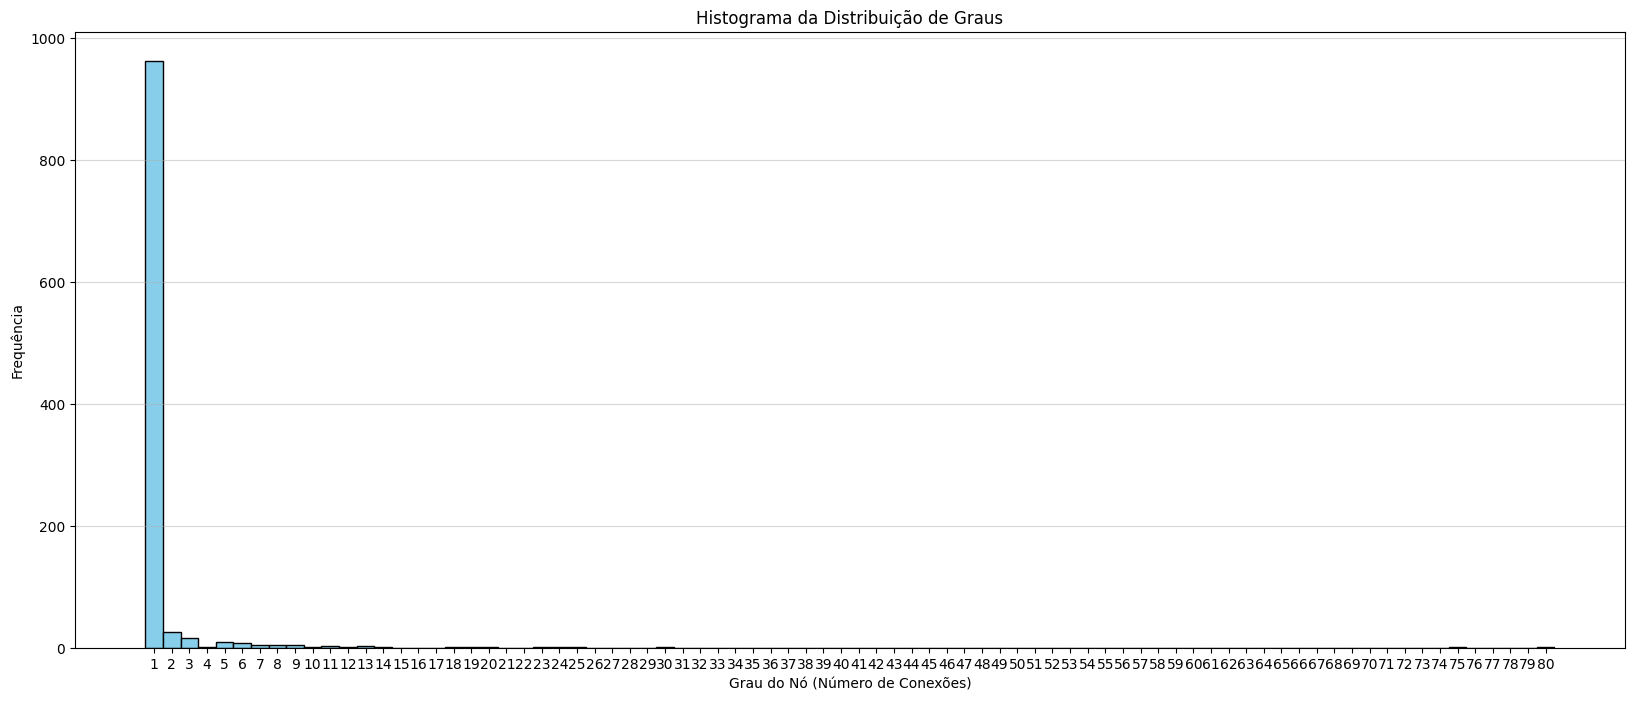

In [ ]:
# DISTRIBUIÇÃO DE PROBABILIDADE/HISTOGRAMA DOS GRAUS

degrees = [degree for node, degree in G.degree()]
plt.figure(figsize=(20, 8))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Histograma da Distribuição de Graus')
plt.xlabel('Grau do Nó (Número de Conexões)')
plt.ylabel('Frequência')
plt.xticks(range(min(degrees), max(degrees) + 1))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
# VISUALIZAÇÃO DO GRAFO (NETWORKX/MATPLOTLIB)

plt.figure(figsize=(15, 15)) # Increased figure size for better visualization
pos = nx.spring_layout(G, k=0.5, seed=42) # Added seed for reproducible layout and adjusted k

# Configuração de Cores e Tamanhos
node_colors = []
node_sizes = []
labels = {}
edge_widths = []

for node in G.nodes():
    if G.nodes[node]['type'] == 'Empresa':
        node_colors.append('red')
        # Size of company nodes based on their degree (number of projects)
        node_sizes.append(G.degree(node) * 50) # Scaled for better visibility
        labels[node] = node
    else: # Obra
        # Cor da obra baseada no Status [3]
        status = G.nodes[node].get('status', 'Unknown') # Handle potential missing status
        if status == 'Atrasada':
            node_colors.append('orange')
        elif status == 'Em Andamento':
             node_colors.append('blue')
        else: # Concluída or Unknown
            node_colors.append('green')

        # Tamanho do nó da obra baseado no valor (ponderação)
        # Get the numeric value from the edge connected to the work node
        # Since it's a bipartite graph, each work node is connected to exactly one company node
        valor_numeric = 0
        for u, v, data in G.edges(node, data=True):
            valor_numeric = data.get('weight', 0)
            break # Assuming one edge per work node in this context

        node_sizes.append(valor_numeric / 5000) # Scaled for better visibility
        labels[node] = str(node) # Mostra o ID da obra

# Desenho dos Nós
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# Desenho das Arestas (Ponderação visual: espessura da linha baseada no valor)
for u, v, data in G.edges(data=True):
    # Escala a largura da aresta (dividir por um fator grande)
    edge_widths.append(data.get('weight', 0) / 500000) # Scaled for better visibility

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, edge_color='gray')

# Desenho dos Rótulos
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8) # Adjusted font size

plt.title('Grafo Bipartido: Obras vs. Empresas (Tamanho pelo Valor do Contrato)')
plt.axis('off')
plt.show()

# ----------------------------------------------------
# Interpretação da Visualização
# A empresa 'Construtora Alfa' (nó vermelho) é um hub de alto grau.
# A Obra 'Nova Biblioteca' (laranja, atrasada) tem o maior valor (maior tamanho).
# ----------------------------------------------------

In [ ]:
def limpar_valor(valor_str):
    """Remove R$, espaços, pontos (milhares) e troca vírgula por ponto (decimal)."""
    if isinstance(valor_str, str):
        # 1. Remove R$ e espaços
        valor_str = valor_str.replace('R$', '').strip()
        # 2. Remove o ponto de milhares ('.')
        valor_str = valor_str.replace('.', '')
        # 3. Troca a vírgula decimal (',') pelo ponto ('.')
        valor_str = valor_str.replace(',', '.')
    try:
        return float(valor_str)
    except ValueError:
        return 0.0 # Retorna zero se a conversão falhar

# Aplica a limpeza
df['valor_float'] = df['valor'].apply(limpar_valor)

# Pré-limpeza da coluna empresa (remover espaços e aspas extras)
df['empresa'] = df['empresa'].str.strip().str.replace('"', '')

print("DataFrame Limpo (Primeiras Linhas e Valores):")
print(df[['id_obra', 'empresa', 'valor', 'valor_float', 'status_obra']].head())

DataFrame Limpo (Primeiras Linhas e Valores):
   id_obra                                            empresa  \
0      478  03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREEN...   
1      521  03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREEN...   
2      925  40.761.454/0001-08 - AR PROJETOS & CONSTRUÇÕES...   
3      493  03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREEN...   
4      848        03.722.669/0001-85 - CONSTRUTORA CAGEO LTDA   

                 valor  valor_float status_obra  
0  R$       847.582,26    847582.26  FINALIZADA  
1  R$       833.702,12    833702.12  FINALIZADA  
2  R$       814.550,74    814550.74  FINALIZADA  
3  R$       829.454,21    829454.21  FINALIZADA  
4  R$     1.561.230,93   1561230.93  FINALIZADA  


In [ ]:
# ----------------------------------------------------
# 2.1 CRIAÇÃO DO GRAFO E ATRIBUIÇÃO DE PARTIÇÕES
# ----------------------------------------------------
G = nx.Graph()

obras_nodes = df['id_obra'].unique()
empresas_nodes = df['empresa'].unique()

# Adiciona Nós de Obras e Empresas com seus atributos
for id_obra in obras_nodes:
    # Get the specific row for the current id_obra using boolean indexing and iloc[0]
    obra_row = df[df['id_obra'] == id_obra].iloc[0]
    G.add_node(id_obra,
               bipartite=0,
               type='Obra',
               status=obra_row['status_obra'],
               valor=obra_row['valor_float'],
               qtd_dias=obra_row['qtd_dias'])

for empresa in empresas_nodes:
    G.add_node(empresa,
               bipartite=1,
               type='Empresa')

# Adiciona Arestas Ponderadas
for index, row in df.iterrows():
    # Aresta ponderada pelo valor_float
    G.add_edge(row['id_obra'],
               row['empresa'],
               weight=row['valor_float'])

print(f"\nGrafo Bipartido criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

In [ ]:
# Se houver poucos dados (como neste exemplo), pulamos a filtragem extrema para não esvaziar o grafo.
if G.number_of_nodes() > 10:

    # 3.1 Identificar Hubs (Exemplo: Top 5 empresas por grau)
    degree_empresas = {n: d for n, d in G.degree() if G.nodes[n]['bipartite'] == 1}
    top_empresas = sorted(degree_empresas, key=degree_empresas.get, reverse=True)[:5]

    # 3.2 Obras de Alto Risco/Valor
    risco_obras = [n for n in G.nodes() if G.nodes[n].get('status') in ['Atrasada', 'Paralisada']]

    # Obras mais caras (ex: acima da média ou do 90º percentil)
    todos_valores = [G.nodes[n]['valor'] for n in G.nodes() if G.nodes[n]['type'] == 'Obra']
    if todos_valores:
        valor_corte = np.percentile(todos_valores, 90)
        valor_obras = [n for n in G.nodes() if G.nodes[n].get('valor', 0) >= valor_corte and G.nodes[n]['type'] == 'Obra']
    else:
        valor_obras = []

    foco_nodes = set(top_empresas) | set(risco_obras) | set(valor_obras)
    G_foco = G.subgraph(foco_nodes).copy()
else:
    # Se o grafo for pequeno (como o exemplo fornecido), visualize o grafo completo
    G_foco = G
    print("Grafo pequeno, visualizando o conjunto completo de nós.")

# Separa as partições do subgrafo de foco
obras_foco = [n for n in G_foco.nodes() if G_foco.nodes[n]['bipartite'] == 0]
empresas_foco = [n for n in G_foco.nodes() if G_foco.nodes[n]['bipartite'] == 1]

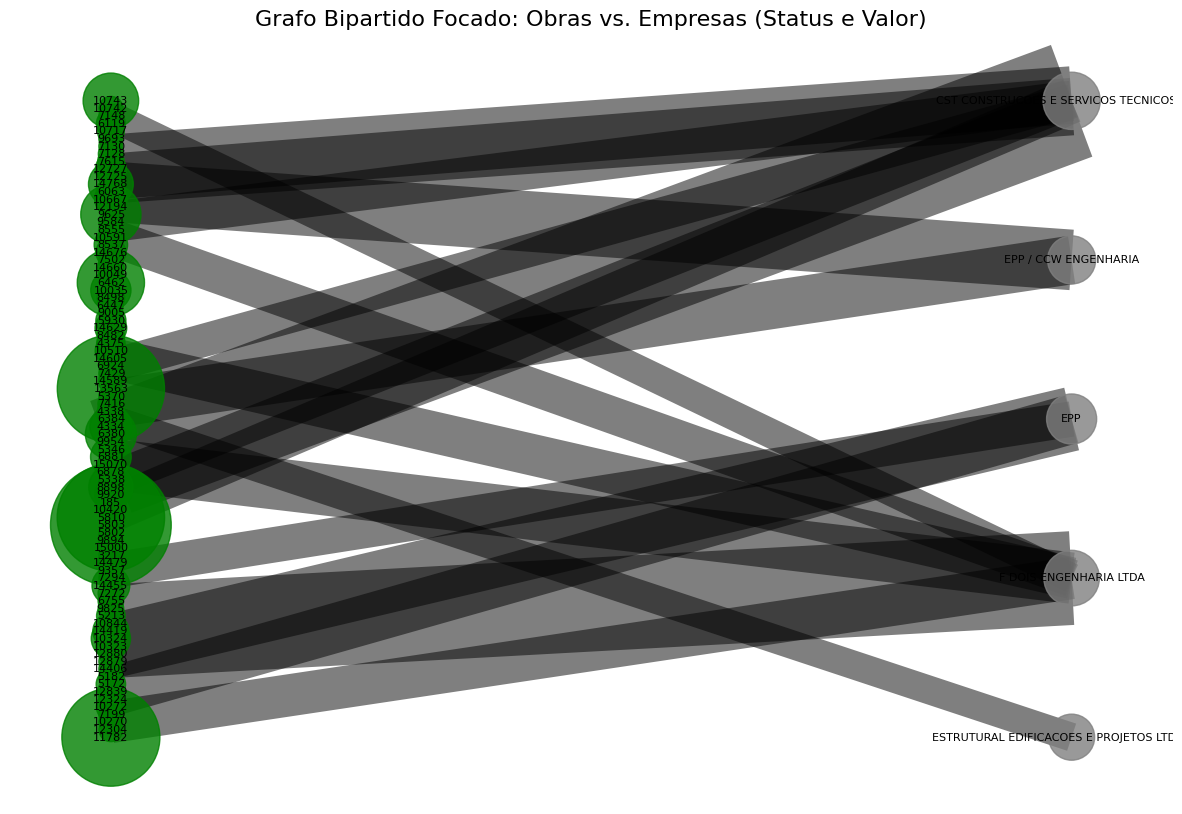

In [ ]:
# ----------------------------------------------------
# 4.1 VISUALIZAÇÃO ESTRUTURADA (LAYOUT BI-PARTIDO)
# ----------------------------------------------------

# Aplica o layout bi-partido (separa Obras e Empresas visualmente)
try:
    pos = nx.bipartite_layout(G_foco, obras_foco)
except ValueError:
    # Se uma das partições estiver vazia após a filtragem, use um layout padrão
    pos = nx.spring_layout(G_foco)


# Configuração de Cores e Tamanhos
node_colors = []
node_sizes = []
labels = {}

for node in G_foco.nodes():
    node_type = G_foco.nodes[node]['type']

    if node_type == 'Empresa':
        node_colors.append('gray') # Empresas em cinza
        node_sizes.append(1000 + G_foco.degree[node] * 100) # Tamanho pelo Grau (Hubs)
        labels[node] = node.split(' - ')[-1] # Usa apenas o nome, se o CNPJ/CPF for longo
    else: # Obra
        status = G_foco.nodes[node]['status']
        valor = G_foco.nodes[node]['valor']

        # Mapeamento de cor pelo Status (Análise de Risco)
        if status in ['Atrasada', 'Paralisada']:
            node_colors.append('red') # Risco
        elif status == 'Em Andamento':
            node_colors.append('orange')
        else: # Finalizada/Concluída
            node_colors.append('green')

        # Tamanho pelo Valor (Ponderação)
        size_scaled = valor / 10000
        node_sizes.append(max(size_scaled, 300))
        labels[node] = node # ID da Obra

# Espessura da aresta pelo Valor
edge_widths = [data['weight'] / 100000 for u, v, data in G_foco.edges(data=True)]

plt.figure(figsize=(15, 10))
plt.title('Grafo Bipartido Focado: Obras vs. Empresas (Status e Valor)', fontsize=16)

# Desenho
nx.draw_networkx_nodes(G_foco, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_foco, pos, width=edge_widths, alpha=0.5, edge_color='black')
nx.draw_networkx_labels(G_foco, pos, labels=labels, font_size=8, verticalalignment='center')

plt.axis('off')
plt.show()


Grafo de Co-ocorrência criado com 205 nós (apenas Empresas).


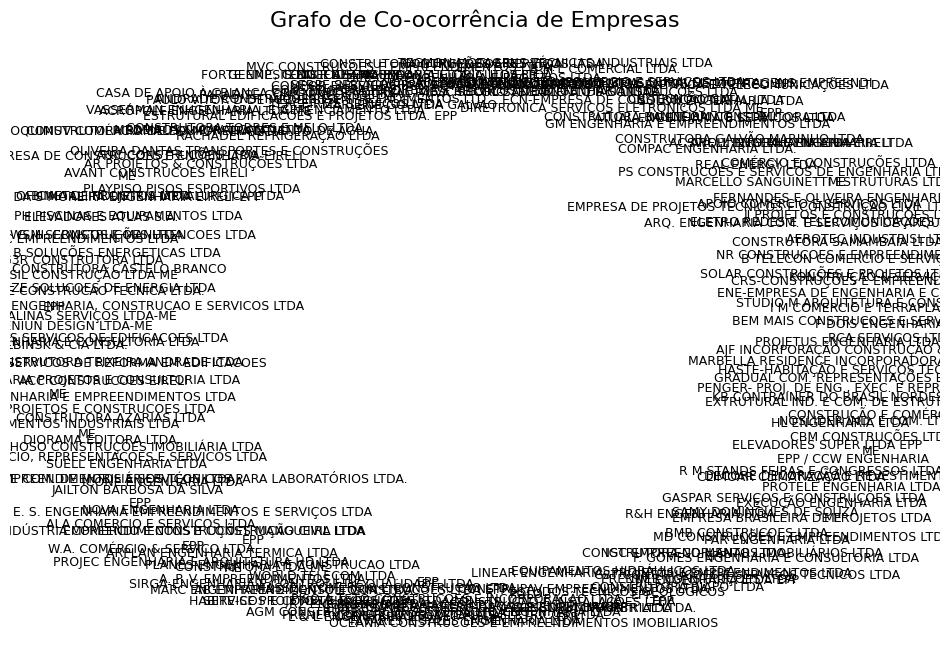

In [ ]:
# ----------------------------------------------------
# 1. CRIANDO O GRAFO DE CO-OCORRÊNCIA (Projeção)
# ----------------------------------------------------

# Vamos projetar a partir da relação Obra-Empresa.
# Duas empresas estão ligadas se trabalharam na mesma Obra (embora seja mais comum ligar por Projeto/Licitação, para demonstração usaremos Obra).

# Criar um grafo de co-ocorrência (monopartido)
G_co = nx.Graph()
empresas_unicas = df['empresa'].unique()
G_co.add_nodes_from(empresas_unicas)

# Dicionário para armazenar a frequência de co-ocorrência
co_ocorrencia = {}

# Itera sobre todas as obras
for id_obra in df['id_obra'].unique():
    # Encontra todas as empresas envolvidas na OBRA
    empresas_na_obra = df[df['id_obra'] == id_obra]['empresa'].tolist()

    # Se houver mais de uma empresa na obra (muito raro em construção, mas comum em licitações/projetos), ligue-as
    if len(empresas_na_obra) >= 2:
        # Cria todas as combinações (pares) de empresas
        from itertools import combinations
        for emp1, emp2 in combinations(empresas_na_obra, 2):
            if emp1 != emp2:
                # Ordena o par para garantir que a chave do dicionário seja única
                par = tuple(sorted((emp1, emp2)))
                co_ocorrencia[par] = co_ocorrencia.get(par, 0) + 1

# 2. Adicionar as Arestas Ponderadas ao Grafo
for (emp1, emp2), peso in co_ocorrencia.items():
    G_co.add_edge(emp1, emp2, weight=peso)

print(f"\nGrafo de Co-ocorrência criado com {G_co.number_of_nodes()} nós (apenas Empresas).")


# ----------------------------------------------------
# 3. VISUALIZAÇÃO DO GRAFO DE CO-OCORRÊNCIA
# ----------------------------------------------------

plt.figure(figsize=(12, 8))
pos_co = nx.spring_layout(G_co, k=0.5) # Spring layout funciona bem em grafos menores

# Calcula o grau dos nós para dimensionamento
degree_map = [G_co.degree(node) * 100 for node in G_co.nodes()]

# Desenha os nós (empresas)
nx.draw_networkx_nodes(G_co, pos_co, node_size=degree_map, node_color='purple', alpha=0.7)

# Desenha as arestas (espessura pelo peso da co-ocorrência)
edges = G_co.edges(data=True)
weights = [d['weight'] for u, v, d in edges]
nx.draw_networkx_edges(G_co, pos_co, width=np.array(weights) * 2, alpha=0.6, edge_color='black')

# Desenha os rótulos
labels = {node: node.split(' - ')[-1] for node in G_co.nodes()} # Limpa os rótulos
nx.draw_networkx_labels(G_co, pos_co, labels=labels, font_size=9)

plt.title("Grafo de Co-ocorrência de Empresas", fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
def limpar_valor(valor_str):
    """Remove R$, espaços, pontos (milhares) e troca vírgula por ponto (decimal)."""
    if isinstance(valor_str, str):
        valor_str = valor_str.replace('R$', '').strip()
        valor_str = valor_str.replace('.', '')
        valor_str = valor_str.replace(',', '.')
    try:
        return float(valor_str)
    except ValueError:
        return 0.0

df['valor_float'] = df['valor'].apply(limpar_valor)

# Trata Unidades Responsáveis vazias ou com apenas aspas (visto no exemplo de dados)
df['unidade_responsavel'] = df['unidade_responsavel'].str.strip().str.replace('"', '')
df['unidade_responsavel'].replace('', 'NAO_INFORMADA', inplace=True)
df['unidade_responsavel'].fillna('NAO_INFORMADA', inplace=True)

print("Limpeza de dados concluída.")

Limpeza de dados concluída.


In [ ]:
# ----------------------------------------------------
# 2.1 CRIAÇÃO DO GRAFO OBRA <--> UNIDADE RESPONSÁVEL
# ----------------------------------------------------
G_unidade = nx.Graph()

obras_nodes = df['id_obra'].unique()
unidades_nodes = df['unidade_responsavel'].unique()

# Adiciona Nós (Partição 0: Obras, Partição 1: Unidades)
for id_obra in obras_nodes:
    obra_data = df[df['id_obra'] == id_obra]
    G_unidade.add_node(id_obra,
                       bipartite=0,
                       type='Obra',
                       status=obra_data['status_obra'].iloc[0],
                       valor=obra_data['valor_float'].iloc[0])

for unidade in unidades_nodes:
    G_unidade.add_node(unidade,
                       bipartite=1,
                       type='Unidade')

# Adiciona Arestas Ponderadas (Peso = Valor da Obra)
for index, row in df.iterrows():
    if row['unidade_responsavel'] != 'NAO_INFORMADA':
        G_unidade.add_edge(row['id_obra'],
                           row['unidade_responsavel'],
                           weight=row['valor_float'])

print(f"Grafo Obra-Unidade criado com {G_unidade.number_of_nodes()} nós e {G_unidade.number_of_edges()} arestas.")

Grafo Obra-Unidade criado com 931 nós e 445 arestas.


In [ ]:
# ----------------------------------------------------
# 3.1 CÁLCULO DO GRAU PONDERADO
# ----------------------------------------------------

# Calcular o grau ponderado (soma dos pesos das arestas)
weighted_degree = G_unidade.degree(weight='weight')

# Filtrar apenas os nós que são Unidades Responsáveis
weighted_degree_unidades = {}
for node, degree in weighted_degree:
    if G_unidade.nodes[node]['type'] == 'Unidade':
        weighted_degree_unidades[node] = degree

# Converter para DataFrame para facilitar a ordenação e visualização
df_analise = pd.DataFrame(
    list(weighted_degree_unidades.items()),
    columns=['Unidade Responsável', 'Valor Total Acumulado']
)

# Ordenar por valor para identificar os hubs financeiros
df_analise = df_analise.sort_values(by='Valor Total Acumulado', ascending=False)

print("\nAnálise de Correlação (Top Unidades por Valor Acumulado):")
print(df_analise)


Análise de Correlação (Top Unidades por Valor Acumulado):
                            Unidade Responsável  Valor Total Acumulado
10                            CAMPUS DO CÉREBRO           1.354275e+08
8                          CENTRO DE TECNOLOGIA           3.862954e+07
5   UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE           3.740631e+07
19            ADMINISTRAÇÃO CENTRAL - GASTOS CT           2.559878e+07
6                         CENTRO DE BIOCIÊNCIAS           1.775708e+07
..                                          ...                    ...
44              SUPERINTENDENCIA DE COMUNICACAO           1.013000e+04
43          DEPARTAMENTO DE ENGENHARIA ELÉTRICA           7.960000e+03
52                    NÚCLEO DE REDES AVANÇADAS           7.938140e+03
42                                TVU/SUPERINT.           4.882880e+03
0                                 NAO_INFORMADA           0.000000e+00

[83 rows x 2 columns]


/tmp/ipython-input-1939643549.py:29: UserWarning:

Glyph 150 (\x96) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 150 (\x96) missing from font(s) DejaVu Sans.



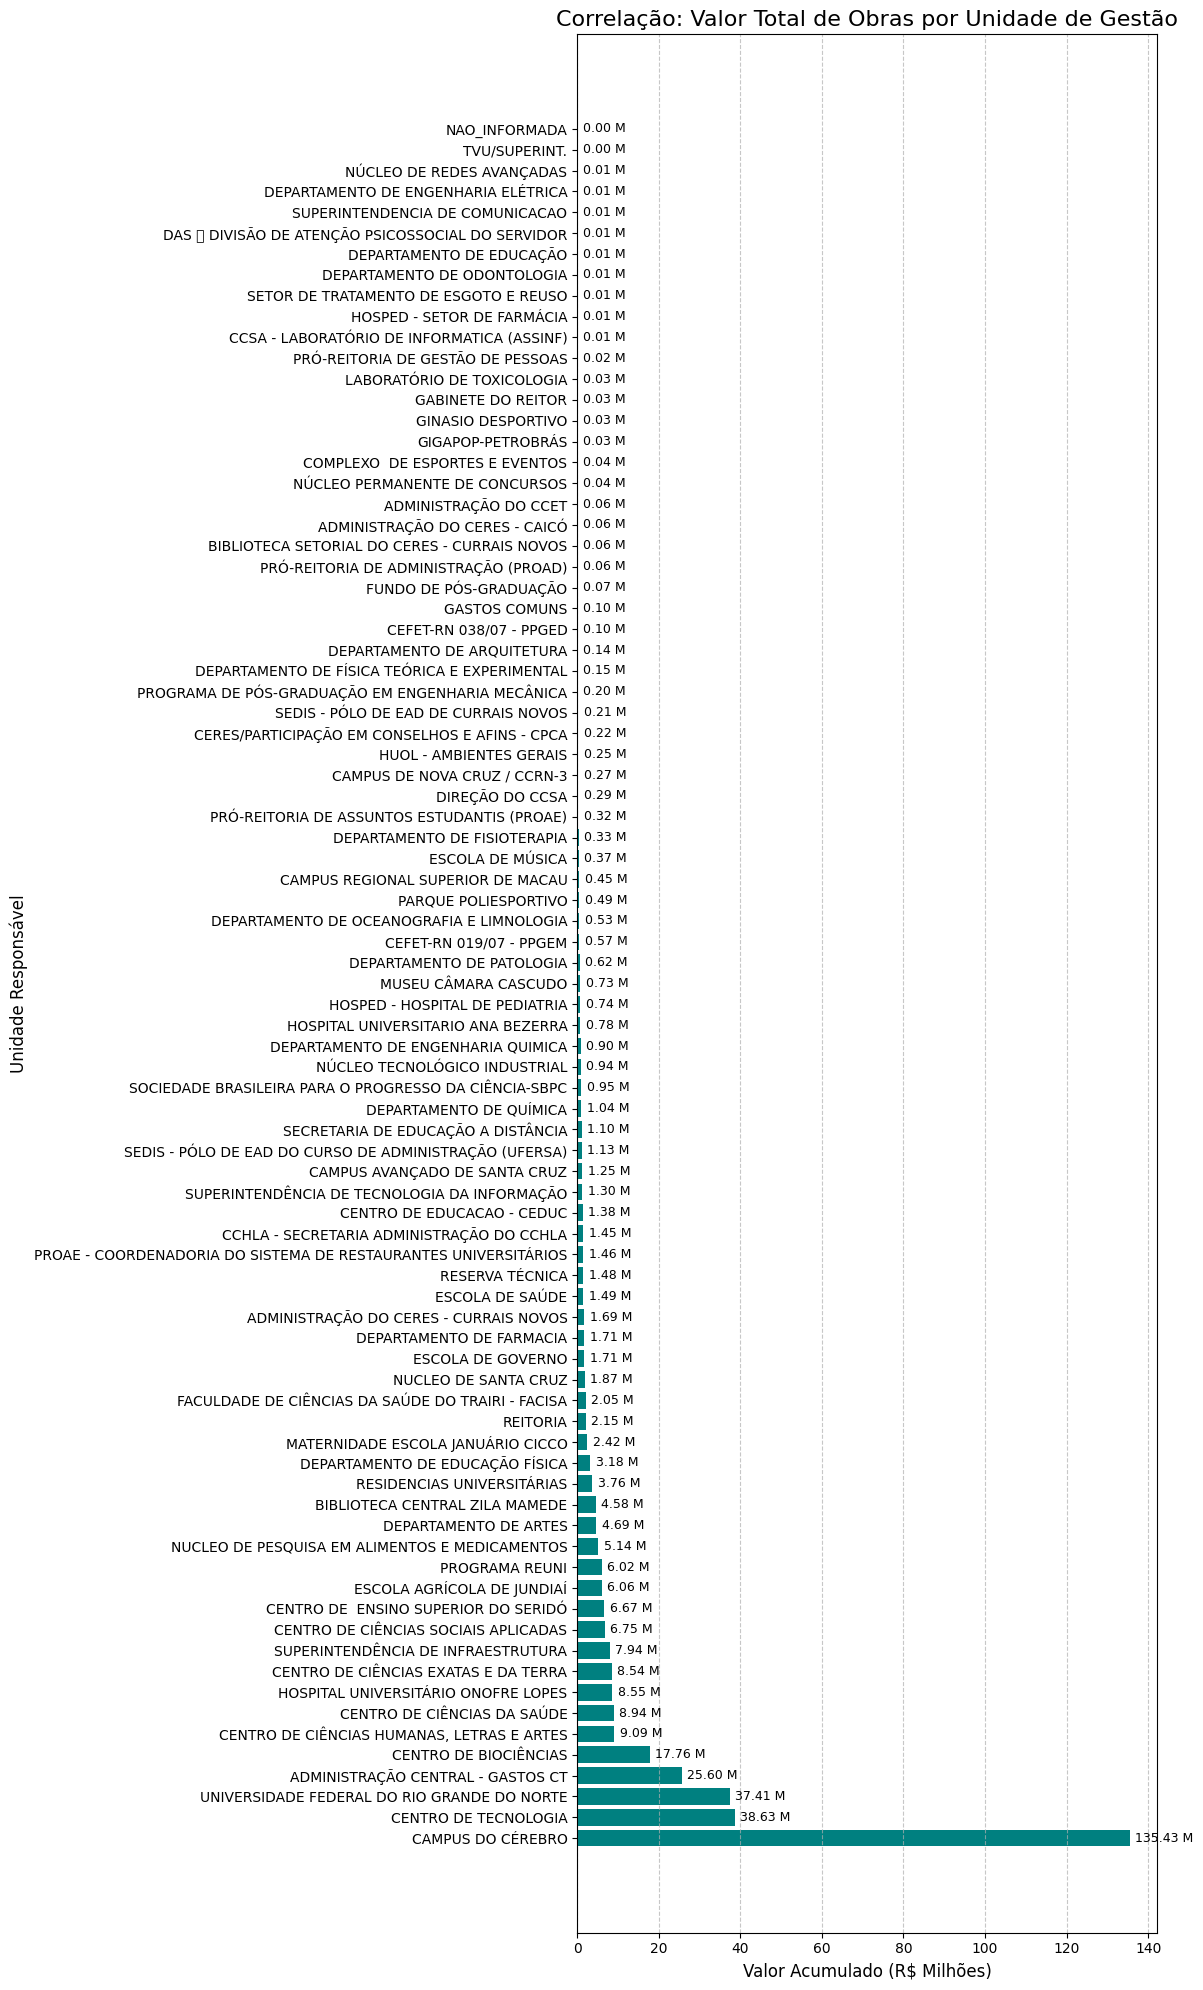

In [ ]:
# VISUALIZAÇÃO DA CORRELAÇÃO - GRÁFICO DE BARRAS HORIZONTAL

plt.figure(figsize=(12,20)) # Aumentamos a altura para acomodar os rótulos horizontais

# Dados para o gráfico
valores = df_analise['Valor Total Acumulado']
unidades = df_analise['Unidade Responsável']

# Convertendo valores para milhões para rótulos mais limpos
valores_milhoes = valores / 1_000_000

# inversão (Horizontal) usando plt.barh
plt.barh(unidades, valores_milhoes, color='teal')

# Rótulos
plt.xlabel('Valor Acumulado (R$ Milhões)', fontsize=12)
plt.ylabel('Unidade Responsável', fontsize=12)
plt.title('Correlação: Valor Total de Obras por Unidade de Gestão', fontsize=16)

# Ajuste do eixo Y (posiciona os rótulos na vertical)
plt.yticks(unidades, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7) # valor em X

# Adicionar o valor exato no final de cada barra (no eixo X)
for i, v in enumerate(valores_milhoes):
    plt.text(v + (valores_milhoes.max() * 0.01), i,
             f'{v:.2f} M', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# ARIADNE

In [ ]:
print("\nInformações sobre as colunas:")
df.info()


Informações sobre as colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   numero_fatura            6 non-null      object 
 1   campus                   6 non-null      object 
 2   tipo_conceito_faturado   6 non-null      object 
 3   valor_conceito_faturado  6 non-null      float64
dtypes: float64(1), object(3)
memory usage: 324.0+ bytes


In [ ]:
# Carregar o arquivo CSV
df = pd.read_csv('obras.csv', sep=';')

# --- Tratamento de Dados Essencial ---
# Com base na análise dos metadados, as colunas 'empresa' e 'unidade_responsavel'
# têm contagens de valores não nulos diferentes do total de entradas.
# Vamos remover as linhas onde qualquer uma dessas colunas essenciais seja nula.
df_limpo = df.dropna(subset=['empresa', 'unidade_responsavel']).copy()

# manter a consistência
df_limpo['empresa'] = df_limpo['empresa'].str.strip()
df_limpo['unidade_responsavel'] = df_limpo['unidade_responsavel'].str.strip()

print(f"Número de registros válidos após a limpeza: {len(df_limpo)}")

Número de registros válidos após a limpeza: 473


In [ ]:
# Criar um grafo vazio não direcionado [4]
B = nx.Graph()

# Extrair listas de nós únicos para cada conjunto
empresas = df_limpo['empresa'].unique()
unidades = df_limpo['unidade_responsavel'].unique()

# Adicionar os nós ao grafo, especificando a qual conjunto pertencem
# O atributo 'bipartite' é uma convenção do NetworkX para identificar os conjuntos
B.add_nodes_from(empresas, bipartite=0)
B.add_nodes_from(unidades, bipartite=1)

# Adicionar as arestas que conectam uma empresa a uma unidade
# Criamos uma lista de tuplas (empresa, unidade_responsavel) a partir do DataFrame
arestas = list(zip(df_limpo['empresa'], df_limpo['unidade_responsavel']))
B.add_edges_from(arestas)

print("\n--- Grafo Bipartido Criado com Sucesso! ---")


--- Grafo Bipartido Criado com Sucesso! ---


In [ ]:
# Verificar as propriedades básicas do grafo
num_empresas = len(empresas)
num_unidades = len(unidades)

print(f"Número de nós do tipo 'Empresa' (Conjunto 0): {num_empresas}")
print(f"Número de nós do tipo 'Unidade Responsável' (Conjunto 1): {num_unidades}")
print(f"Número total de nós (vértices): {B.number_of_nodes()}")
print(f"Número total de arestas (conexões): {B.number_of_edges()}")

# Verificar se o grafo é de fato bipartido (o NetworkX tem uma função para isso)
if nx.is_bipartite(B):
    print("\nConfirmação: O grafo é bipartido.")
else:
    print("\nAlerta: O grafo não foi construído como bipartido.")

Número de nós do tipo 'Empresa' (Conjunto 0): 125
Número de nós do tipo 'Unidade Responsável' (Conjunto 1): 82
Número total de nós (vértices): 207
Número total de arestas (conexões): 331

Confirmação: O grafo é bipartido.


In [ ]:
# Calcular o grau de todos os nós
graus = dict(B.degree())

# Separar os graus por tipo de nó (empresa vs. unidade) para facilitar a análise
graus_empresas = {node: grau for node, grau in graus.items() if B.nodes[node]['bipartite'] == 0}
graus_unidades = {node: grau for node, grau in graus.items() if B.nodes[node]['bipartite'] == 1}

# Ordenar para ver os mais conectados (top 5)
top_5_empresas = sorted(graus_empresas.items(), key=lambda item: item[1], reverse=True)[:5]
top_5_unidades = sorted(graus_unidades.items(), key=lambda item: item[1], reverse=True)[:5]

print("--- Análise de Centralidade de Grau ---")
print("\nTop 5 Empresas com mais conexões (unidades diferentes):")
for empresa, grau in top_5_empresas:
    print(f"- {empresa}: {grau} conexões")

print("\nTop 5 Unidades com mais conexões (empresas diferentes):")
for unidade, grau in top_5_unidades:
    print(f"- {unidade}: {grau} conexões")

--- Análise de Centralidade de Grau ---

Top 5 Empresas com mais conexões (unidades diferentes):
- 09.389.289/0001-57 - AC ENGENHARIA LTDA - EPP: 18 conexões
- 04.751.986/0001-92 - F DOIS ENGENHARIA LTDA: 17 conexões
- 04.201.519/0001-99 - ESTRUTURAL EDIFICACOES E PROJETOS LTDA. EPP: 14 conexões
- 04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E CONSTRUÇÃO CIVIL LTDA: 10 conexões
- 05.952.175/0001-12 - PROJETUS ENGENHARIA LTDA: 10 conexões

Top 5 Unidades com mais conexões (empresas diferentes):
- UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE: 57 conexões
- CENTRO DE TECNOLOGIA: 24 conexões
- CENTRO DE CIÊNCIAS EXATAS E DA TERRA: 15 conexões
- HOSPITAL UNIVERSITÁRIO ONOFRE LOPES: 14 conexões
- CENTRO DE CIÊNCIAS DA SAÚDE: 14 conexões


In [ ]:
# Calcular o grau médio
grau_medio = sum(graus.values()) / B.number_of_nodes()
print(f"\nGrau médio da rede: {grau_medio:.2f}")

# Calcular a densidade do grafo bipartido
# A densidade para grafos bipartidos é E / (N1 * N2)
# onde N1 e N2 são o número de nós em cada partição.
num_empresas = len(graus_empresas)
num_unidades = len(graus_unidades)
densidade_bipartida = B.number_of_edges() / (num_empresas * num_unidades)

print(f"Densidade da rede bipartida: {densidade_bipartida:.4f}")


Grau médio da rede: 3.20
Densidade da rede bipartida: 0.0323


In [ ]:

# Pegar apenas os valores dos graus
graus_valores = list(graus.values())

# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.hist(graus_valores, bins=range(1, max(graus_valores) + 1), alpha=0.75)
plt.title('Distribuição de Grau da Rede de Obras')
plt.xlabel('Grau (Número de Conexões)')
plt.ylabel('Frequência (Número de Nós)')
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# Limpeza e preparação para o Grafo Bipartido
# Conforme os metadados, precisamos das colunas 'empresa' e 'unidade_responsavel' sem nulos [3, 4]
df_bipartido = df.dropna(subset=['empresa', 'unidade_responsavel']).copy()
df_bipartido['empresa'] = df_bipartido['empresa'].str.strip()
df_bipartido['unidade_responsavel'] = df_bipartido['unidade_responsavel'].str.strip()
print(f"Registros válidos para o grafo bipartido: {len(df_bipartido)}")
print("-" * 50 + "\n")

# Bloco 2: Criação do grafo
print("--- Iteração 2: Transformando Dados em um Grafo Bipartido ---")

B = nx.Graph()

# Extrair nós únicos para cada partição
empresas = list(df_bipartido['empresa'].unique())
unidades = list(df_bipartido['unidade_responsavel'].unique())

# Adicionar nós com atributos para identificar o tipo (bipartite) e para os labels
B.add_nodes_from(empresas, bipartite=0, tipo='Empresa')
B.add_nodes_from(unidades, bipartite=1, tipo='Unidade')

# Adicionar arestas
arestas_bipartido = list(zip(df_bipartido['empresa'], df_bipartido['unidade_responsavel']))
B.add_edges_from(arestas_bipartido)

print("Grafo Bipartido (B) criado.")
print(f"  - Nós: {B.number_of_nodes()} ({len(empresas)} Empresas, {len(unidades)} Unidades)")
print(f"  - Arestas: {B.number_of_edges()}")
print("-" * 50 + "\n")

Registros válidos para o grafo bipartido: 473
--------------------------------------------------

--- Iteração 2: Transformando Dados em um Grafo Bipartido ---
Grafo Bipartido (B) criado.
  - Nós: 207 (125 Empresas, 82 Unidades)
  - Arestas: 331
--------------------------------------------------



In [ ]:
# --- VISUALIZAÇÃO DO GRAFO ---

print("Iniciando a visualização do grafo...")

# 1. Definir posições para o layout bipartido
pos = dict()
cores_nos = []
tamanhos_nos = []

# Identify the two sets of nodes based on the 'bipartite' attribute
empresas_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]
unidades_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]


# Posições para as empresas (lado esquerdo, x=0)
pos.update((node, (0, i)) for i, node in enumerate(empresas_nodes))
# Posições para as unidades (lado direito, x=1)
pos.update((node, (1, i)) for i, node in enumerate(unidades_nodes))

# 2. Definir cores e tamanhos para os nós
graus = dict(B.degree())
for node in B.nodes():
    if B.nodes[node]['bipartite'] == 0:  # Se for empresa
        cores_nos.append('skyblue')
    else:  # Se for unidade
        cores_nos.append('lightgreen')
    # O tamanho do nó será proporcional ao seu grau (multiplicado por um fator para melhor visualização)
    tamanhos_nos.append(graus[node] * 100)

# 3. Desenhar o grafo
plt.figure(figsize=(12, 18))  # Ajuste o tamanho conforme necessário
nx.draw(B,
        pos=pos,
        with_labels=True,
        node_color=cores_nos,
        node_size=tamanhos_nos,
        font_size=8,
        font_color='black',
        width=0.5,  # Espessura das arestas
        alpha=0.8)

# 4. Adicionar legendas e título
plt.title("Grafo Bipartido: Relações entre Empresas e Unidades Responsáveis", fontsize=16)
# Adicionando uma legenda manual
plt.text(-0.1, max(len(empresas_nodes), len(unidades_nodes)), 'Empresas', color='skyblue', fontweight='bold')
plt.text(1.05, max(len(empresas_nodes), len(unidades_nodes)), 'Unidades', color='lightgreen', fontweight='bold')

plt.show()

print("Visualização gerada com sucesso!")

In [ ]:
# Bloco 3: Análise das métricas do grafo
print("--- Iteração 3: Analisando o Grafo ---")

# Calcular grau de cada nó
graus = B.degree()
nx.set_node_attributes(B, dict(graus), 'grau')

# Identificar a empresa e unidade com maior grau
graus_empresas = {n: g for n, g in graus if B.nodes[n]['bipartite'] == 0}
top_empresa = sorted(graus_empresas.items(), key=lambda x: x[1], reverse=True)[0] # Corrected index to 1 and get the top one
print(f"Empresa mais conectada: '{top_empresa[0]}' com {top_empresa[1]} conexões.") # Corrected indexing for printing

graus_unidades = {n: g for n, g in graus if B.nodes[n]['bipartite'] == 1}
top_unidade = sorted(graus_unidades.items(), key=lambda x: x[1], reverse=True)[0] # Get the top one
print(f"Unidade mais conectada: '{top_unidade[0]}' com {top_unidade[1]} conexões.") # Corrected indexing for printing


# Calcular a densidade da rede bipartida
# Need to explicitly define the partitions for bipartite density
empresas_nodes = [n for n, data in B.nodes(data=True) if data['bipartite'] == 0]
unidades_nodes = [n for n, data in B.nodes(data=True) if data['bipartite'] == 1]
densidade_b = nx.bipartite.density(B, nodes=empresas_nodes) # Pass one set of nodes

print(f"Densidade da rede bipartida: {densidade_b:.4f}")
print("-" * 50 + "\n")

--- Iteração 3: Analisando o Grafo ---
Empresa mais conectada: '09.389.289/0001-57 - AC ENGENHARIA LTDA - EPP' com 18 conexões.
Unidade mais conectada: 'UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE' com 57 conexões.
Densidade da rede bipartida: 0.0323
--------------------------------------------------



In [ ]:
# Bloco 4: Visualização interativa com Plotly
print("--- Iteração 4: Gerando Visualização Interativa com Plotly ---")

# 1. Calcular a posição dos nós usando o layout bipartido do NetworkX
pos = nx.bipartite_layout(B, empresas)

# 2. Criar o trace das arestas
edge_x = []
edge_y = []
for edge in B.edges():
    x0, y0 = pos[edge[0]] # Get the position of the first node in the edge tuple
    x1, y1 = pos[edge[1]] # Get the position of the second node in the edge tuple
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# 3. Criar o trace dos nós
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in B.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

    # Adicionar informações para o hover e estilo
    grau = B.nodes[node]['grau']
    tipo = B.nodes[node]['tipo']
    node_text.append(f"<b>{node}</b><br>Tipo: {tipo}<br>Conexões: {grau}")
    node_size.append(10 + grau * 3) # Tamanho baseado no grau
    node_color.append('skyblue' if tipo == 'Empresa' else 'lightgreen')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=False,
        color=node_color,
        size=node_size,
        line_width=2))

# 4. Criar a figura e exibir
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Grafo Bipartido Interativo: Relações entre Empresas e Unidades',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Passe o mouse sobre um nó para ver os detalhes. Use o zoom para explorar.",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

print("Visualização interativa gerada! Verifique a nova janela/aba do seu navegador.")
print("-" * 50 + "\n")
print("Processo iterativo concluído!")

--- Iteração 4: Gerando Visualização Interativa com Plotly ---


ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'titlefont'

Did you mean "title"?

    Valid properties:
        activeselection
            :class:`plotly.graph_objects.layout.Activeselection`
            instance or dict with compatible properties
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        barcornerradius
            Sets the rounding of bar corners. May be an integer
            number of pixels, or a percentage of bar width (as a
            string ending in %).
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to reduce
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendiciclecolors
            If `true`, the icicle slice colors (whether given by
            `iciclecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to reduce "opacity" to
            see multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            `hiddenlabels`.
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled.
        hoversubplots
            Determines expansion of hover effects to other subplots
            If "single" just the axis pair of the primary point is
            included without overlaying subplots. If "overlaying"
            all subplots using the main axis and occupying the same
            space are included. If "axis", also include stacked
            subplots using the same axis when `hovermode` is set to
            "x", *x unified*, "y" or *y unified*.
        iciclecolorway
            Sets the default icicle slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendiciclecolors`.
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        map
            :class:`plotly.graph_objects.layout.Map` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        minreducedheight
            Minimum height of the plot with margin.automargin
            applied (in px)
        minreducedwidth
            Minimum width of the plot with margin.automargin
            applied (in px)
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newselection
            :class:`plotly.graph_objects.layout.Newselection`
            instance or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        scattergap
            Sets the gap (in plot fraction) between scatter points
            of adjacent location coordinates. Defaults to `bargap`.
        scattermode
            Determines how scatter points at the same location
            coordinate are displayed on the graph. With "group",
            the scatter points are plotted next to one another
            centered around the shared location. With "overlay",
            the scatter points are plotted over one another, you
            might need to reduce "opacity" to see multiple scatter
            points.
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        selections
            A tuple of
            :class:`plotly.graph_objects.layout.Selection`
            instances or dicts with compatible properties
        selectiondefaults
            When used in a template (as
            layout.template.layout.selectiondefaults), sets the
            default property values to use for elements of
            layout.selections
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        smith
            :class:`plotly.graph_objects.layout.Smith` instance or
            dict with compatible properties
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to reduce "opacity" to see
            multiple bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "title"?

Bad property path:
titlefont_size
^^^^^^^^^